<a href="https://colab.research.google.com/github/ritwikdubey/bitcoin-onchain-price-direction-prediction/blob/main/TCN_CNN_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

hello


In [ ]:
!pip install tensorflow-addons
!pip install -q keras-tcn --no-dependencies
!pip install boruta
#!pip install pyfolio



import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.decomposition import PCA
from keras.layers import BatchNormalization,LSTM
from tcn import TCN
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
# reset the seeds for reproducibility
def reset_random_seeds():
    n = 1
    os.environ['PYTHONHASHSEED'] = str(n)
    tf.random.set_seed(n)
    np.random.seed(n)
    random.seed(n)

reset_random_seeds()
hor = 1

import numpy as np
import pandas as pd
from google.colab import drive
import datetime
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/MyDrive/CombinedData.csv')

df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df = df.set_index('timestamp')
delete_col = ["accumulation_trend_score_price", "active_more_1y_percent", "hodl_waves_1y_2y",
              "hodl_waves_2y_3y", "hodl_waves_3y_5y", "hodl_waves_5y_7y", "hodl_waves_7y_10y",
              "hodl_waves_more_10y", "provably_lost_burn", "provably_lost_op_return",
              "provably_lost_unclaimed", "rcap_hodl_waves_1y_2y", "rcap_hodl_waves_2y_3y",
              "rcap_hodl_waves_3y_5y", "rcap_hodl_waves_5y_7y", "rcap_hodl_waves_7y_10y",
              "rcap_hodl_waves_more_10y", "soab_1y_2y", "soab_2y_3y", "soab_3y_5y", "soab_5y_7y",
              "soab_7y_10y", "soab_more_10y", "stock_to_flow_ratio_price", "svab_1y_2y", "svab_2y_3y",
              "svab_3y_5y", "svab_5y_7y", "svab_7y_10y", "svab_more_10y", "svl_more_10y","price_usd_ohlc_c"]
#df = df.drop(columns=delete_col).loc[pd.to_datetime('2012-12-13'):]

#filter df based on date
df = df.drop(columns=delete_col)[df.index >= pd.to_datetime('2012-12-13')]

# selected cols
selected_cols = ['cdd90_age_adjusted', 'sopr_adjusted','average_dormancy','cdd','mvrv','mvrv_z_score','net_realized_profit_loss','net_unrealized_profit_loss','utxo_loss_count',	'utxo_profit_count',
                 'utxo_profit_relative','profit_relative','price_drawdown_relative','price_usd_ohlc_c',	'price_usd_ohlc_h',	'price_usd_ohlc_l',	'price_usd_ohlc_o', 'puell_multiple', 'realized_loss',
                 'realized_profit_loss_ratio','realized_profits_to_value_ratio','unrealized_loss', 'unrealized_profit','cdd_supply_adjusted','loss_sum','profit_sum']

col_df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Boruta_onchain_data.csv', index_col='timestamp', parse_dates=['timestamp']).loc[df.index]
df['price_ohlc_usd_c'] = col_df['price-ohlc-usd-c']
omole_col = col_df.columns.str.replace("-","_")
omole_col

# My data
X = df
#y = np.where(df['price_usd_ohlc_o'].shift(-hor) > df['price_usd_ohlc_o'], 1, 0)

# Omole data
# X = col_df
y = np.where(col_df['price-ohlc-usd-c'].shift(-1) > col_df['price-ohlc-usd-c'], 1, 0)

Mounted at /content/gdrive


In [ ]:
df

,accumulation_trend_score_score,active_1d_1w,active_1m_3m,active_1w_1m,active_24h,active_3m_6m,active_6m_12m,active_count,asol,average_dormancy,...,utxo_spent_count,utxo_spent_value_mean,utxo_spent_value_median,utxo_spent_value_sum,velocity,volume_mean,volume_median,volume_mined_sum,volume_sum,price_ohlc_usd_c
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-12-13,0.105200,514933.948946,1.510188e+06,836212.766848,403991.681033,1.172474e+06,1.242829e+06,45850,27.065069,2.502606,...,95867,40.011078,0.106605,3.835742e+06,0.357128,0.001065,0.000500,3275.00,45.133939,13.691131
2012-12-14,0.120594,621942.212495,1.491722e+06,825853.774509,314322.442051,1.182391e+06,1.244037e+06,41453,14.614476,1.186667,...,83717,34.948227,0.119868,2.925761e+06,0.270546,0.000825,0.000500,2650.00,32.110409,13.684013
2012-12-15,0.113955,716732.221780,1.520523e+06,799505.441963,217051.770528,1.178175e+06,1.243346e+06,34372,18.303901,1.097251,...,67419,24.540050,0.102500,1.654466e+06,0.151626,0.000755,0.000500,2900.00,24.340470,13.531920
2012-12-16,0.096515,740388.612706,1.539485e+06,772464.356907,181672.767667,1.194978e+06,1.247062e+06,35514,11.973383,1.554718,...,74622,23.850085,0.059577,1.779741e+06,0.164550,0.000787,0.000500,2775.00,27.822157,13.563107
2012-12-17,0.097343,651349.534950,1.512620e+06,789947.891725,251372.589790,1.221842e+06,1.250158e+06,40773,13.366314,1.138557,...,82074,21.900796,0.106117,1.797486e+06,0.161878,0.000812,0.000500,3350.00,33.217521,13.342400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,0.155936,525406.953808,1.360707e+06,789117.132299,180153.914442,1.514500e+06,1.796938e+06,898884,20.103543,18.953873,...,1072004,0.789612,0.001312,8.464671e+05,0.018372,0.000506,0.000231,1062.50,339.767719,27749.649572
2023-05-11,0.083502,514764.362029,1.423438e+06,778137.422901,169155.356396,1.485295e+06,1.812252e+06,836309,23.751808,15.049537,...,967452,0.882466,0.001554,8.537438e+05,0.025890,0.000356,0.000099,943.75,194.378122,27546.552065
2023-05-12,0.018723,507915.212511,1.447299e+06,754931.326313,187945.728363,1.466736e+06,1.801294e+06,814124,19.189378,19.450683,...,920337,1.043842,0.001811,9.606861e+05,0.021366,0.000341,0.000134,881.25,173.443426,27052.502448


In [ ]:

# scale the input data
scaler = StandardScaler()
feat_df = df.iloc[:int(0.8*df.shape[0])]
feat_y = y[:int(0.8*df.shape[0])]
X_train_scaled = pd.DataFrame(scaler.fit_transform(feat_df.values),
                          index=feat_df.index,
                          columns=feat_df.columns)
# Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_train_scaled.values, feat_y)
selected_feat = X_train_scaled.columns[(feat_selector.support_)]
boruta_feat = selected_feat

# L1
feat_selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000))
feat_selector.fit(X_train_scaled, feat_y)
selected_feat_1 = X_train_scaled.columns[(feat_selector.get_support())]
l1_feat = selected_feat_1

# PCA
# n_comp = 20
# pca = PCA(n_components=n_comp)
# pca.fit(X_train_scaled)
# X_scaled = pd.DataFrame(scaler.transform(df.values),
#                           index=df.index,
#                           columns=df.columns)
# pca_df = pd.DataFrame(data = pca.transform(X_scaled),columns = ['PC%s' % _ for _ in range(n_comp)], index=df.index)
# selected_feat = pca_df.columns

display(selected_feat)
#display(pca_df)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	196
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	164
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	18
Rejected: 	164
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	18
Rejected: 	164
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	18
Rejected: 	164
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	18
Rejected: 	164
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	16
Rejected: 	166
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	16
Rejected: 	166
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	16
Rejected: 	166
Iteration: 	16 / 100
Confirmed: 	1

Index(['cdd', 'cdd_supply_adjusted', 'loss_sum', 'mvrv', 'mvrv_z_score',
       'net_realized_profit_loss', 'net_unrealized_profit_loss',
       'price_drawdown_relative', 'price_usd_ohlc_o', 'profit_relative',
       'profit_sum', 'rcap_hodl_waves_1d_1w', 'rcap_hodl_waves_1w_1m',
       'rcap_hodl_waves_24h', 'realized_loss',
       'realized_profits_to_value_ratio', 'realized_profit',
       'realized_profit_loss_ratio', 'sopr_adjusted', 'sopr', 'svl_1m_3m',
       'unrealized_loss', 'utxo_loss_count', 'utxo_profit_relative',
       'price_ohlc_usd_c'],
      dtype='object')

In [ ]:
timesteps = 5
#timesteps_list = [5]
model_perf = pd.DataFrame(columns=['model','window','accuracy','precision','recall','f1 score'])
#for timesteps in timesteps_list:
#X = pca_df[selected_feat]
X_new = df[selected_feat]

# separate training data from testing data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, shuffle=False)

# scale the input data
scaler = StandardScaler()

# reshape X_train and X_test if they are 1D
'''
if X_train.ndim == 1:
    X_train = X_train.to_numpy().reshape(-1, 1)
if X_test.ndim == 1:
    X_test = X_test.to_numpy().reshape(-1, 1)
'''
# PCA
# X_train_scaled = X_train
# X_test_scaled = X_test

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# function to reshape the input data for model as (samples, timesteps, features)
def create_sequences(data, timesteps):
    X = []
    for i in range(len(data) - timesteps + 1):
        X.append(data[i:i + timesteps])
    return np.array(X)

X_train_reshaped = create_sequences(X_train_scaled, timesteps)
X_test_reshaped = create_sequences(X_test_scaled, timesteps)
y_train = y_train[timesteps - 1:]
y_test = y_test[timesteps - 1:]

# calculate f1_score to use within model training
from tensorflow.keras import backend as K
def f1_score_2(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32') # Cast y_true to float32
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#define TCN model
# model_tcn = Sequential()
# model_tcn.add(TCN(input_shape=(timesteps, X_train_reshaped.shape[2]),
#               nb_filters=64,
#               kernel_size=3,
#               dilations=[1, 2, 4, 8],
#               activation='relu',
#               return_sequences=True))
# model_tcn.add(Dropout(0.5))
# model_tcn.add(TCN(nb_filters=64,
#               kernel_size=3,
#               dilations=[1, 2, 4, 8, 16],
#               activation='relu',
#               return_sequences=False))
# model_tcn.add(Dropout(0.5))
# model_tcn.add(Dense(1, activation='sigmoid'))
# # compile the model
# model_tcn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',  metrics=[metrics.BinaryAccuracy(),
#                                                                                         metrics.Precision(), metrics.Recall(), f1_score_2])

# CNN LSTM model
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(timesteps, X_train_reshaped.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(units=32, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=True, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',  metrics=[metrics.BinaryAccuracy(),
                                                                                        metrics.Precision(), metrics.Recall(), f1_score_2])

# train with the training dataset
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(X_train_reshaped, y_train, epochs=1000, batch_size=50, verbose=0,validation_split=0.1, callbacks=[early_stopping])

# predict with testing dataset
y_pred_prob = model.predict(X_test_reshaped)

# convert probabilities to binary class labels
y_pred = (y_pred_prob >= 0.5).astype(int)

# evaluate the prediction performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
row_df = pd.DataFrame([['cnn_lstm',timesteps, acc, prec, rec, f1]], columns=['model','window','accuracy','precision','recall','f1 score'])
model_perf = pd.concat([model_perf, row_df],axis=0)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

time = X.index
time_train, time_test = train_test_split(time, test_size=0.2, shuffle=False)
time_test = time_test[timesteps-1:]

# Flatten y_pred to be a 1-dimensional array
y_pred_flat = y_pred.flatten()

# Create a DataFrame with columns time_test, y_test, and y_pred
pred_res = pd.DataFrame({'date': time_test, 'actual': y_test, 'prediction': y_pred_flat})

pred_res.head()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy: 0.8269484808454426
Precision: 0.8098958333333334
Recall: 0.8428184281842819
F1-score: 0.8260292164674635


<ipython-input-6-1f251def668a>:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_perf = pd.concat([model_perf, row_df],axis=0)


,date,actual,prediction
0,2021-04-18,0,0
1,2021-04-19,0,1
2,2021-04-20,1,1
3,2021-04-21,0,0
4,2021-04-22,0,0


In [ ]:
model_perf

,model,window,accuracy,precision,recall,f1 score
0,cnn_lstm,5,0.826948,0.809896,0.842818,0.826029


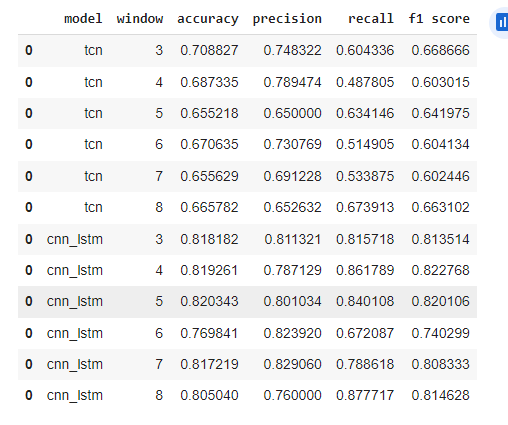

In [ ]:
model.predict(np.array([X_test[-timesteps:]]))
X_test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


(761, 25)

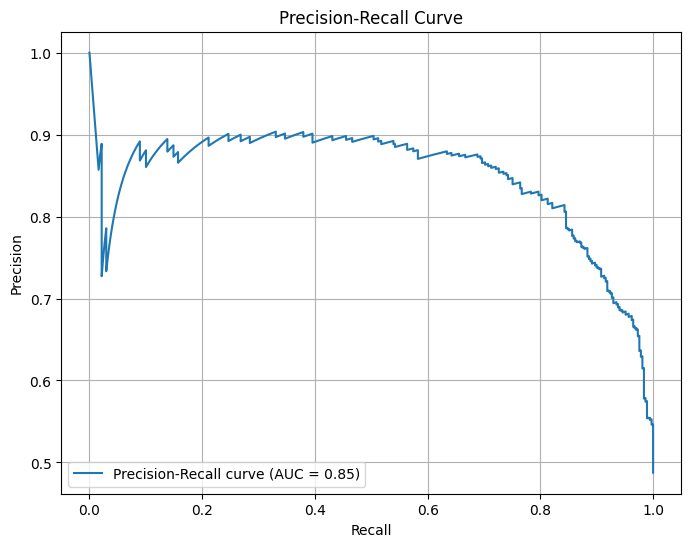

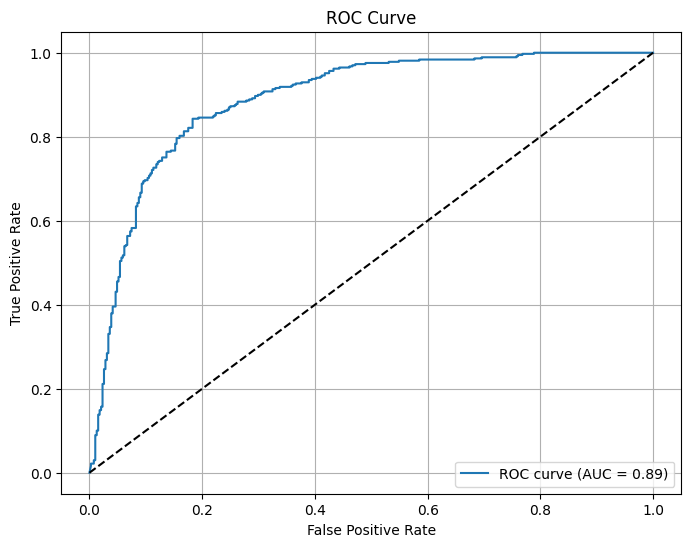

In [ ]:
# prompt: plot precision recall curve and AUC curve

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming you have y_test (true labels) and y_pred_prob (predicted probabilities)
#  y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Random Forest
from sklearn.metrics import confusion_matrix
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_new, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_rf_train)
X_test_scaled = scaler.transform(X_rf_test)
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_rf_train)
y_pred = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_rf_test, y_pred))
print("Precision:", precision_score(y_rf_test, y_pred))
print("Recall:", recall_score(y_rf_test, y_pred))
print("F1-score:", f1_score(y_rf_test, y_pred))

Accuracy: 0.5164257555847569
Precision: 0.5357142857142857
Recall: 0.04054054054054054
F1-score: 0.07537688442211055


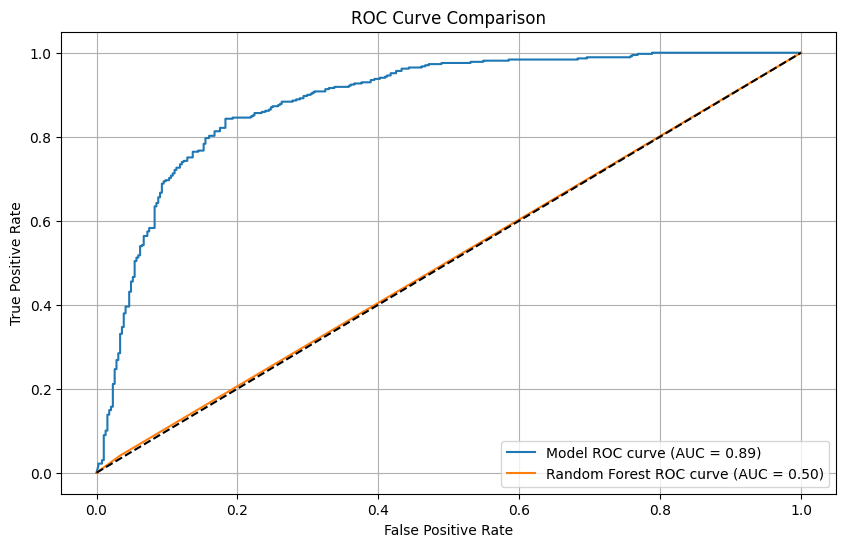

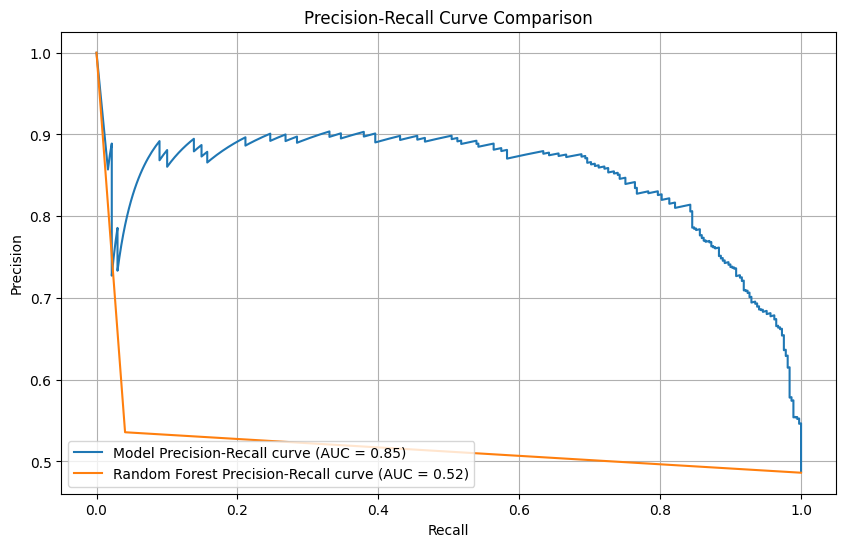

In [ ]:
# prompt: generate roc curve and precision recall curve for model and rf_model for comparison

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Assuming y_test is the true labels and you have predictions for both models
# y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class from your model
# y_pred_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1] # Probability for positive class from rf_model


# ROC Curve
plt.figure(figsize=(10, 6))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model ROC curve (AUC = {roc_auc:.2f})')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_rf_test, y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')


plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Precision-Recall Curve

plt.figure(figsize=(10, 6))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'Model Precision-Recall curve (AUC = {pr_auc:.2f})')

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_rf_test, y_pred)
pr_auc_rf = auc(recall_rf, precision_rf)
plt.plot(recall_rf, precision_rf, label=f'Random Forest Precision-Recall curve (AUC = {pr_auc_rf:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
# def long_only(price, ind):
#   hold = False
#   if ind ==1 and hold is False :
#     buy_price = price
#     sell_price = 0
#     hold = True
#   elif ind == 0 and hold is True:
#     sell_price = price
#     profit = 1 + (sell_price-buy_price)/buy_price
#     hold = False
#   else:
#     profit = 0

test_data['return'] = test_data['price_ohlc_usd_c'].pct_change()
test_data['cum_return'] = (1+test_data['return']).cumprod() -1
test_data['return_pos'] = test_data['return']
test_data['return_pos'][test_data['return'] < 0] = 0
test_data['cum_return_pos'] = (1+test_data['return_pos']).cumprod() -1

test_data['return_neg'] = test_data['return']
test_data['return_neg'][test_data['return']>=0] = 0
test_data['return_neg'] = -test_data['return_neg']
test_data['cum_return_neg'] = (test_data['return_neg']+1).cumprod() -1

test_data['return_pos_neg'] = test_data['return']*test_data['y_test'].replace({0:-1}).shift(hor)
test_data['return_pos_neg'] = test_data['return_pos_neg']
test_data['cum_return_pos_neg'] = (1+test_data['return_pos_neg']).cumprod() -1

#commission = 0.005
commission = 0.01
# add tax, splippage numbers, refer papers for these numbers
test_data['new_ind_pos'] = test_data['return']*test_data['y_pred'].shift(hor)
test_data['new_ind_pos'] = np.where(test_data['new_ind_pos'] !=0, test_data['new_ind_pos'] - commission*test_data['pred_change'], test_data['new_ind_pos'])
test_data['cum_new_ind_pos'] = (1+test_data['new_ind_pos']).cumprod() -1
test_data['new_ind_neg'] = -test_data['return']*((~test_data['y_pred'].astype(bool)).astype(int).shift(hor))
test_data['new_ind_neg'] = np.where(test_data['new_ind_neg'] !=0, test_data['new_ind_neg'] - commission*test_data['pred_change'], test_data['new_ind_neg'])
test_data['cum_new_ind_neg'] = (1+test_data['new_ind_neg']).cumprod() -1
test_data['new_ind_pos_neg'] = test_data['return']*test_data['y_pred'].replace({0:-1}).shift(hor)
test_data['new_ind_pos_neg'] = test_data['new_ind_pos_neg'] - commission*2*test_data['pred_change']
test_data['cum_new_ind_pos_neg'] = (1+test_data['new_ind_pos_neg']).cumprod() -1

test_data.to_csv('gdrive/MyDrive/boruta_cnn_lstm_hor1_result_4-16.csv')
test_data

<ipython-input-22-a649ecbdf212>:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_data['return_pos'][test_data['return'] < 0] = 0
<ipython-input-22-a649ecbdf212>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,price_ohlc_usd_c,y_test,y_pred,pred_change,return,cum_return,return_pos,cum_return_pos,return_neg,cum_return_neg,return_pos_neg,cum_return_pos_neg,new_ind_pos,cum_new_ind_pos,new_ind_neg,cum_new_ind_neg,new_ind_pos_neg,cum_new_ind_pos_neg
timestamp,,,,,,,,,,,,,,,,,,
2021-04-18,60271.001851,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-19,56672.928394,0,1,1.0,-0.059698,-0.059698,0.000000,0.000000,0.059698,0.059698,0.059698,5.969825e-02,-0.000000,0.000000,0.049698,0.049698,0.039698,0.039698
2021-04-20,54687.833507,1,1,0.0,-0.035027,-0.092634,0.000000,0.000000,0.035027,0.096817,0.035027,9.681653e-02,-0.035027,-0.035027,0.000000,0.049698,-0.035027,0.003281
2021-04-21,55790.115870,0,0,1.0,0.020156,-0.074346,0.020156,0.020156,-0.000000,0.096817,0.020156,1.189239e-01,0.010156,-0.025227,-0.000000,0.049698,0.000156,0.003437
2021-04-22,54124.349710,0,0,0.0,-0.029858,-0.101984,0.000000,0.020156,0.029858,0.129565,0.029858,1.523324e-01,-0.000000,-0.025227,0.029858,0.081040,0.029858,0.033397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-10,27749.649572,0,0,1.0,0.005686,-0.539585,0.005686,6688.322004,-0.000000,9026.162107,0.005686,6.038559e+07,-0.004314,173.939010,-0.000000,246.003981,-0.014314,719.220437
2023-05-11,27546.552065,0,0,0.0,-0.007319,-0.542955,0.000000,6688.322004,0.007319,9092.231198,0.007319,6.082755e+07,-0.000000,173.939010,0.007319,247.811784,0.007319,724.491674
2023-05-12,27052.502448,0,0,0.0,-0.017935,-0.551152,0.000000,6688.322004,0.017935,9255.319028,0.017935,6.191850e+07,-0.000000,173.939010,0.017935,252.274243,0.017935,737.503425
